Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [2]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289 (from 1)
Receiving objects: 100% (289/289), 24.28 MiB | 11.09 MiB/s, done.
Resolving deltas: 100% (155/155), done.


# Import libs

In [38]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [39]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

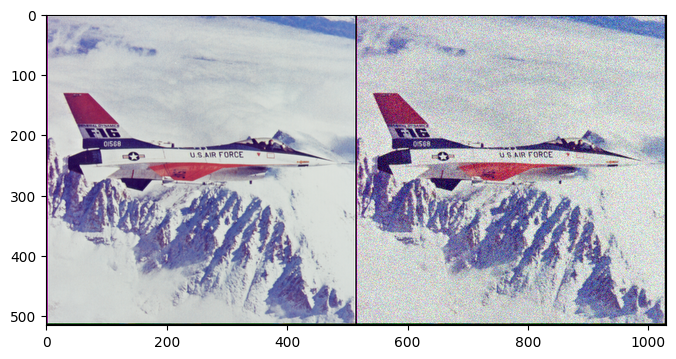

In [40]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)

    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np

    if PLOT:
        plot_image_grid([img_np], 4, 5);

elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [41]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 500
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5

    net = skip(
                input_depth, 3,
                num_channels_down = [8, 16, 32, 64, 128],
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4],
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32
    figsize = 4


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


In [42]:
psrn_noisy = compare_psnr(img_noisy_np, img_np)
print('PSRN noisy: %f' % psrn_noisy)

PSRN noisy: 20.357939


# Optimize

Starting optimization with ADAM
Iteration 00000    Loss 0.088960   PSRN_gt: 10.939362 PSNR_gt_sm: 10.939362


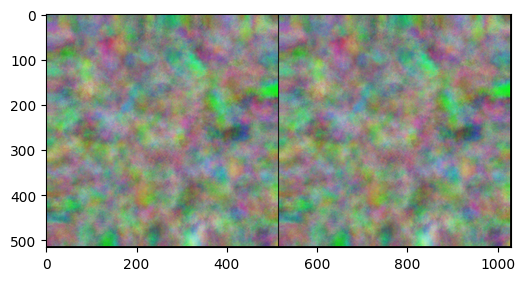

Iteration 00001    Loss 0.076346   PSRN_gt: 11.683780 PSNR_gt_sm: 10.969018
Iteration 00002    Loss 0.055013   PSRN_gt: 13.337480 PSNR_gt_sm: 11.016371
Iteration 00003    Loss 0.075115   PSRN_gt: 11.774900 PSNR_gt_sm: 11.066581
Iteration 00004    Loss 0.048487   PSRN_gt: 14.022696 PSNR_gt_sm: 11.135661
Iteration 00005    Loss 0.043378   PSRN_gt: 14.629710 PSNR_gt_sm: 11.206659
Iteration 00006    Loss 0.036949   PSRN_gt: 15.521882 PSNR_gt_sm: 11.273656
Iteration 00007    Loss 0.037149   PSRN_gt: 15.488541 PSNR_gt_sm: 11.337831
Iteration 00008    Loss 0.035335   PSRN_gt: 15.779188 PSNR_gt_sm: 11.399747
Iteration 00009    Loss 0.035477   PSRN_gt: 15.758917 PSNR_gt_sm: 11.462416
Iteration 00010    Loss 0.032792   PSRN_gt: 16.226371 PSNR_gt_sm: 11.528273
Iteration 00011    Loss 0.031974   PSRN_gt: 16.380191 PSNR_gt_sm: 11.595093
Iteration 00012    Loss 0.031369   PSRN_gt: 16.496191 PSNR_gt_sm: 11.662344
Iteration 00013    Loss 0.030463   PSRN_gt: 16.673774 PSNR_gt_sm: 11.728285
Iteration 00

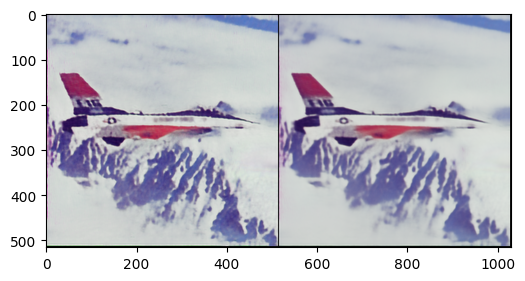

Iteration 00501    Loss 0.011720   PSRN_gt: 25.734755 PSNR_gt_sm: 26.144469
Iteration 00502    Loss 0.011691   PSRN_gt: 25.751323 PSNR_gt_sm: 26.157478
Iteration 00503    Loss 0.011664   PSRN_gt: 25.794873 PSNR_gt_sm: 26.169814
Iteration 00504    Loss 0.011771   PSRN_gt: 25.637361 PSNR_gt_sm: 26.181749
Iteration 00505    Loss 0.011723   PSRN_gt: 25.705605 PSNR_gt_sm: 26.193486
Iteration 00506    Loss 0.011680   PSRN_gt: 25.779821 PSNR_gt_sm: 26.205668
Iteration 00507    Loss 0.011716   PSRN_gt: 25.716733 PSNR_gt_sm: 26.217949
Iteration 00508    Loss 0.011764   PSRN_gt: 25.637106 PSNR_gt_sm: 26.229544
Iteration 00509    Loss 0.011663   PSRN_gt: 25.819442 PSNR_gt_sm: 26.240626
Iteration 00510    Loss 0.011745   PSRN_gt: 25.683738 PSNR_gt_sm: 26.251720
Iteration 00511    Loss 0.011710   PSRN_gt: 25.715591 PSNR_gt_sm: 26.264635
Iteration 00512    Loss 0.011665   PSRN_gt: 25.800088 PSNR_gt_sm: 26.277833
Iteration 00513    Loss 0.011662   PSRN_gt: 25.801501 PSNR_gt_sm: 26.289134
Iteration 00

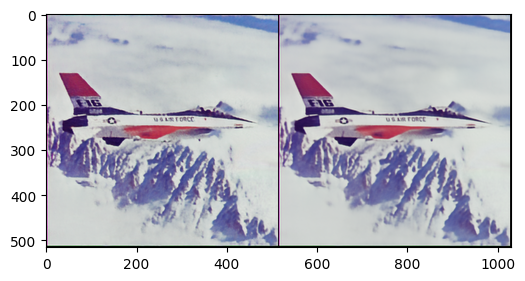

Iteration 01001    Loss 0.010464   PSRN_gt: 28.222095 PSNR_gt_sm: 29.859053
Iteration 01002    Loss 0.010417   PSRN_gt: 28.402582 PSNR_gt_sm: 29.863850
Iteration 01003    Loss 0.010397   PSRN_gt: 28.408357 PSNR_gt_sm: 29.868189
Iteration 01004    Loss 0.010410   PSRN_gt: 28.410179 PSNR_gt_sm: 29.872813
Iteration 01005    Loss 0.010385   PSRN_gt: 28.462206 PSNR_gt_sm: 29.877597
Iteration 01006    Loss 0.010434   PSRN_gt: 28.333289 PSNR_gt_sm: 29.881567
Iteration 01007    Loss 0.010430   PSRN_gt: 28.356028 PSNR_gt_sm: 29.885863
Iteration 01008    Loss 0.010392   PSRN_gt: 28.456159 PSNR_gt_sm: 29.890784
Iteration 01009    Loss 0.010435   PSRN_gt: 28.346438 PSNR_gt_sm: 29.895725
Iteration 01010    Loss 0.010393   PSRN_gt: 28.456170 PSNR_gt_sm: 29.898537
Iteration 01011    Loss 0.010404   PSRN_gt: 28.407198 PSNR_gt_sm: 29.902485
Iteration 01012    Loss 0.010434   PSRN_gt: 28.362343 PSNR_gt_sm: 29.907752
Iteration 01013    Loss 0.010420   PSRN_gt: 28.389863 PSNR_gt_sm: 29.911695
Iteration 01

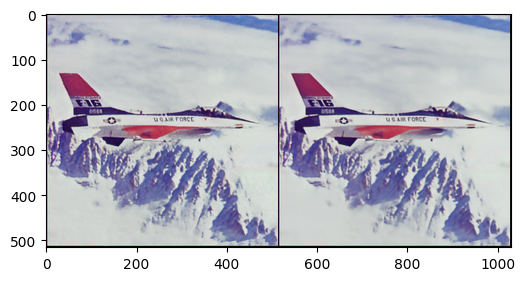

Iteration 01501    Loss 0.009936   PSRN_gt: 29.638618 PSNR_gt_sm: 31.473808
Iteration 01502    Loss 0.009953   PSRN_gt: 29.595063 PSNR_gt_sm: 31.475850
Iteration 01503    Loss 0.009911   PSRN_gt: 29.781363 PSNR_gt_sm: 31.478885
Iteration 01504    Loss 0.009913   PSRN_gt: 29.767688 PSNR_gt_sm: 31.481342
Iteration 01505    Loss 0.009951   PSRN_gt: 29.597983 PSNR_gt_sm: 31.483079
Iteration 01506    Loss 0.009918   PSRN_gt: 29.737269 PSNR_gt_sm: 31.485288
Iteration 01507    Loss 0.009931   PSRN_gt: 29.708841 PSNR_gt_sm: 31.486849
Iteration 01508    Loss 0.009951   PSRN_gt: 29.560763 PSNR_gt_sm: 31.489421
Iteration 01509    Loss 0.009924   PSRN_gt: 29.668929 PSNR_gt_sm: 31.491899
Iteration 01510    Loss 0.009919   PSRN_gt: 29.695460 PSNR_gt_sm: 31.493900
Iteration 01511    Loss 0.009922   PSRN_gt: 29.710943 PSNR_gt_sm: 31.495835
Iteration 01512    Loss 0.009900   PSRN_gt: 29.826799 PSNR_gt_sm: 31.497428
Iteration 01513    Loss 0.009896   PSRN_gt: 29.821034 PSNR_gt_sm: 31.500238
Iteration 01

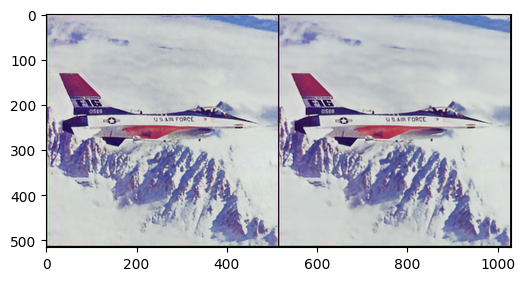

Iteration 02001    Loss 0.009629   PSRN_gt: 30.365629 PSNR_gt_sm: 32.269140
Iteration 02002    Loss 0.009653   PSRN_gt: 30.194312 PSNR_gt_sm: 32.270499
Iteration 02003    Loss 0.009682   PSRN_gt: 30.090194 PSNR_gt_sm: 32.269614
Iteration 02004    Loss 0.009640   PSRN_gt: 30.357971 PSNR_gt_sm: 32.270730
Iteration 02005    Loss 0.009619   PSRN_gt: 30.384681 PSNR_gt_sm: 32.272082
Iteration 02006    Loss 0.009653   PSRN_gt: 30.232214 PSNR_gt_sm: 32.272897
Iteration 02007    Loss 0.009679   PSRN_gt: 30.145789 PSNR_gt_sm: 32.274241
Iteration 02008    Loss 0.009618   PSRN_gt: 30.407988 PSNR_gt_sm: 32.275642
Iteration 02009    Loss 0.009647   PSRN_gt: 30.241751 PSNR_gt_sm: 32.276067
Iteration 02010    Loss 0.009647   PSRN_gt: 30.268541 PSNR_gt_sm: 32.277552
Iteration 02011    Loss 0.009633   PSRN_gt: 30.300610 PSNR_gt_sm: 32.278684
Iteration 02012    Loss 0.009639   PSRN_gt: 30.189804 PSNR_gt_sm: 32.279494
Iteration 02013    Loss 0.009622   PSRN_gt: 30.377840 PSNR_gt_sm: 32.280622
Iteration 02

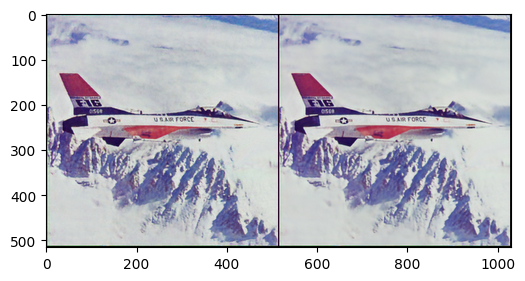

Iteration 02501    Loss 0.009403   PSRN_gt: 30.394270 PSNR_gt_sm: 32.558607
Iteration 02502    Loss 0.009413   PSRN_gt: 30.486895 PSNR_gt_sm: 32.560487
Iteration 02503    Loss 0.009393   PSRN_gt: 30.485741 PSNR_gt_sm: 32.560378
Iteration 02504    Loss 0.009385   PSRN_gt: 30.481233 PSNR_gt_sm: 32.560777
Iteration 02505    Loss 0.009382   PSRN_gt: 30.501569 PSNR_gt_sm: 32.560011
Iteration 02506    Loss 0.009374   PSRN_gt: 30.525910 PSNR_gt_sm: 32.559501
Iteration 02507    Loss 0.009396   PSRN_gt: 30.443589 PSNR_gt_sm: 32.559933
Iteration 02508    Loss 0.009388   PSRN_gt: 30.493497 PSNR_gt_sm: 32.560100
Iteration 02509    Loss 0.009373   PSRN_gt: 30.561735 PSNR_gt_sm: 32.559940
Iteration 02510    Loss 0.009386   PSRN_gt: 30.518268 PSNR_gt_sm: 32.560581
Iteration 02511    Loss 0.009396   PSRN_gt: 30.469784 PSNR_gt_sm: 32.560263
Iteration 02512    Loss 0.009383   PSRN_gt: 30.528043 PSNR_gt_sm: 32.561292
Iteration 02513    Loss 0.009380   PSRN_gt: 30.411274 PSNR_gt_sm: 32.560039
Iteration 02

In [43]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
loss_values = []
psnr_values = []
psnr_sm_values = []

i = 0
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    loss_values.append(total_loss.item())
    # psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0])
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])
    psnr_values.append(psrn_gt)
    psnr_sm_values.append(psrn_gt_sm)
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_gt, psrn_gt_sm))
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize)

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

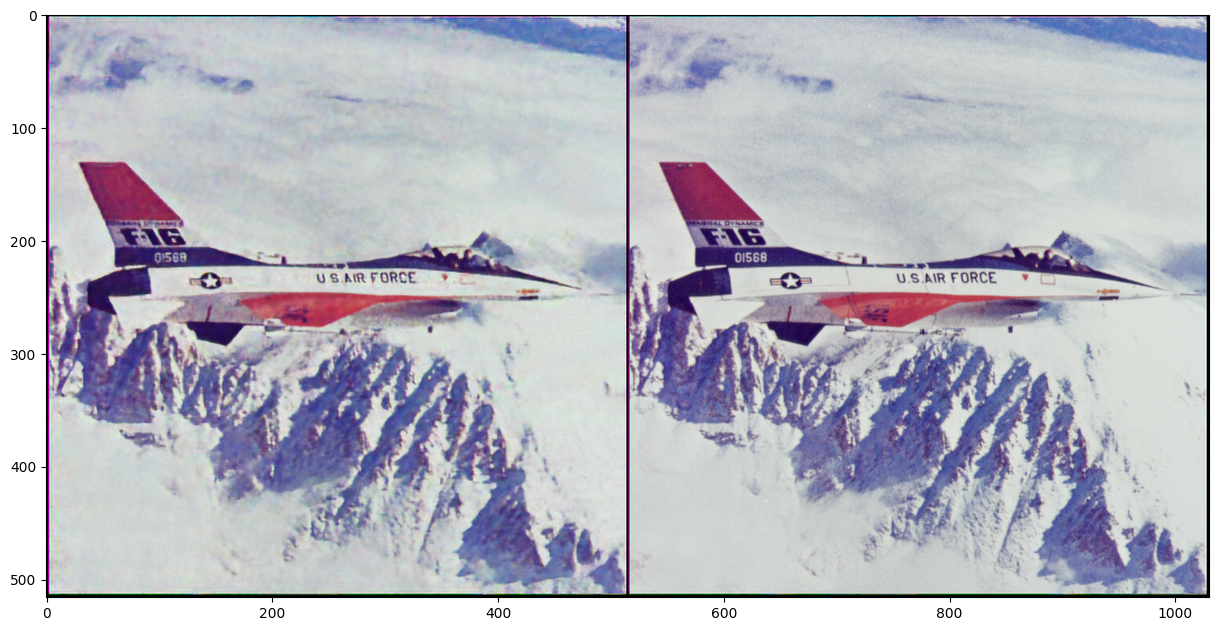

In [44]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

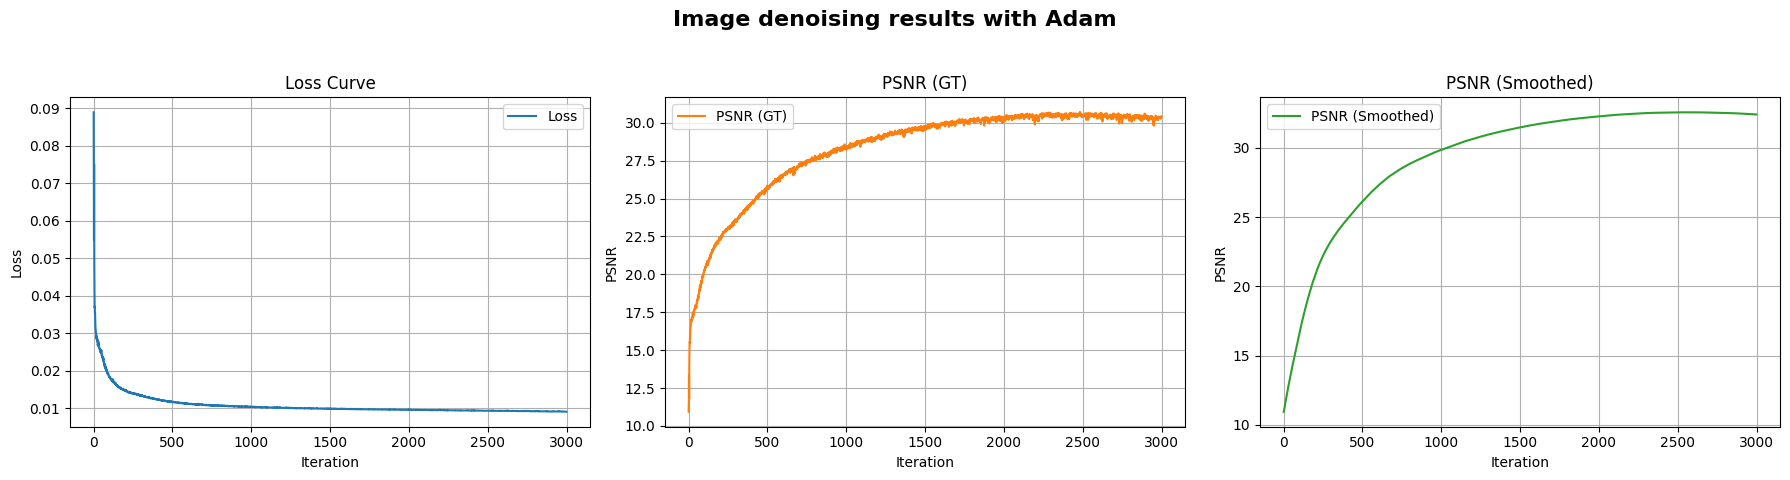

In [45]:
import matplotlib.pyplot as plt

# 创建横向 3 张子图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1行3列

# ---- (1) Loss ----
axes[0].plot(range(len(loss_values)), loss_values, label='Loss', color='tab:blue')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()
axes[0].grid(True)

# ---- (2) PSNR (GT) ----
axes[1].plot(range(len(psnr_values)), psnr_values, label='PSNR (GT)', color='tab:orange')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('PSNR')
axes[1].set_title('PSNR (GT)')
axes[1].legend()
axes[1].grid(True)

# ---- (3) PSNR (Smoothed) ----
axes[2].plot(range(len(psnr_sm_values)), psnr_sm_values, label='PSNR (Smoothed)', color='tab:green')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('PSNR')
axes[2].set_title('PSNR (Smoothed)')
axes[2].legend()
axes[2].grid(True)

# 设置总标题
fig.suptitle('Image denoising results with Adam', fontsize=16, fontweight='bold')

# 自动调整布局，避免重叠
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
